# Face detection using Single Shot Detector (SSD)

So far, you have worked with multiple models for object detection (R-CNN, Fast R-CNN, and Faster R-CNN), but we haven't discussed two families (approaches) of algorithms for object detection.

There are algorithms considered to be **two-stage detectors** (e.g. Faster R-CNN) and **single-stage detectors** (e.g. SSD, RetinaNet). The main difference is in the approach of finding the region of interest and finally making predictions.

#### Two-stage detectors
In two-stage detectors, models first predict region proposals and use them to make predictions. This process can be done as a joint part of the main architecture, one example of this model is Faster R-CNN, or it can be done separately - which slows the prediction time.

#### Single-stage detectors
With good optimization, two-stage detectors can reach a pretty decent prediction speed, almost in real-time. Still, this performance needed to be much more stable for some applications (e.g., Factory security cameras). That's where SSDs come into action. 

Algorithms from this family don't calculate ROIs, cropping them and making predictions based on those regions. Instead, these algorithms directly predict coordinates from the image. By removing the ROI calculation step, these algorithms are much faster in the prediction time and can be used for real-time detection. 

To learn more about the differences between these algorithms:

- Algorithm comparison: https://github.com/yehengchen/Object-Detection-and-Tracking/blob/master/Two-stage%20vs%20One-stage%20Detectors.md
- Stackoverflow answers: https://stackoverflow.com/questions/65942471/one-stage-vs-two-stage-object-detection
- Single-shot Multibox predictors: https://medium.com/@ManishChablani/ssd-single-shot-multibox-detector-explained-38533c27f75f
- SSD multibox object detection: https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab


In [1]:
from IPython.display import IFrame

In [2]:
IFrame("https://www.youtube.com/embed/44tlnmmt3h0", 1000, 500)

**In some cases, IPython widgets do not work!**

If this is the case here is the link for the YouTube video from cell above: https://www.youtube.com/watch?v=44tlnmmt3h0

## Task introduction

![SSD](https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png)
<center>Images taken from: <a href="https://developers.arcgis.com/python/guide/how-ssd-works/">here</a></center>
<br><br>

In this notebook, you will implement a face detection application using a simplified version of the SSD algorithm, optimized to work well on detecting faces.

![faces](https://i.stack.imgur.com/1Jyhp.png)
<center>Images taken from: <a href="https://stackoverflow.com/questions/32586203/opencv-restrict-face-detection-only-in-correct-orientation">here</a></center>
<br><br>

SSD Algorithm is the first from the single-shot (one-shot) object detection algorithms that you'll cover. It does not produce any ROIs but directly predicts coordinates of bounding boxes.


### Steps:
1. Import dependencies
2. Downloading the dataset
3. Processing images
4. Training and test generators
5. Convolutional block
6. Residual Block
7. SSD Model
8. Training and prediction time

### Topics covered and learning objectives
- Sing-shot predictors/detectors
- SSD model
- Confidence and location losses
- Residual blocks

### Time estimates:
- Reading/Watching materials: 3h 20min
- Exercises: 1h 30min
<br><br>
- **Total**: ~5h


### Imports for the project

In [31]:
from pathlib import PurePath, Path
import os
import cv2
import glob
import pickle
import random
import numpy as np
import tensorflow as tf
from random import shuffle
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D, Reshape

from tests import test_process_img, test_conv_block, test_residual_block
# Custom helper functions
# GO CHECK THEM OUT IN utils.py
from utils import IoU, get_outputs, get_anchor, plot_example, plot_pred, get_outputs

## Let's download the dataset

Dataset used in this tutorial is called Face Detection DataBase (FDDB), you can download it from this website - http://vis-www.cs.umass.edu/fddb/

When you get there, you'll see a section that looks like this:
![](images/download.png)

Download both files - **Original, annotated set of images** and **Face annotations**. If you are done with this step, you should have two **zip** files:
- originalPics.zip
- FDDB-folds.zip

Extract both of them in the working directory or **data/module_4** folder inside the root of the repo for the following to work!

FDDB folder should have a lot of **txt** files, and the image directory two subfolders called **2002** and **2003**.

This dataset has about **25.000** images, but we have one problem with their labels. Each face label is not a rectangle, but an ellipse. So before training the model, we have to convert those ellipses into bounding boxes.


#### NOTE: For this task, we will use one size Anchor boxes of 4x4 because of the face shapes

In [26]:
ANCHOR_SIZE = 4
IMG_SIZE = 128
BATCH_SIZE = 64

In [22]:
# Get all txt files with elipse annotations
REPO_DIR = Path(os.getcwd()).parent

faces_dir = REPO_DIR / "data/module_4/face_detection"
annotations_dir = REPO_DIR / "data/module_4/FDDB-folds"
annot_files = glob.glob((annotations_dir / '*ellipseList.txt').__str__())

In [28]:
# This code was taken from the original repo for this dataset
data = {}
for file in annot_files:
    with open(file, 'r') as f:
        rows = f.readlines()
        
    j = len(rows)
    i = 0   
    while(i < j):
        file_name = (faces_dir / (rows[i].replace('\n', '')+'.jpg')).__str__()

        # Number of bounding boxes
        num_boxes = int(rows[i+1])
        boxes = []

        img = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        
        # Make sure that we take all ellipses per image 
        for k in range(1, num_boxes+1):
            box = rows[i+1+k]
            box = box.split()[0:5]
            box = [float(x) for x in box]

            # Convert ellipse to bounding box
            xmin = int(box[3]- box[1])
            ymin = int(box[4]- box[0])
            xmax = int(xmin + box[1]*2)
            ymax = int(ymin + box[0]*2)
            boxes.append([xmin/w, ymin/h, xmax/w, ymax/h])
        
        # convert the boxes to a volume of fixed size 
        data[file_name] = get_outputs(boxes, ANCHOR_SIZE)
        i = i + num_boxes+2

### Exercise 1: Implement image processing function

In the cell below, complete the **process_img** function by following the following steps:
- It should accept two arguments: path to the image and image_size, which is **integer**
- Load it using OpenCV
- Convert it from BGR to RGB
- Resize the image to the image size provided as the argument (interpolation should be linear)
- Normalize the picture, so all pixels are between 0-1

In [29]:
def process_img(img_path, img_size):
    """
    Processes the input image.
    
    Processing steps:
     - Load 
     - BGR -> RGB
     - Resize
     - Normalize
     
    Args:
        img_path :string: - disk location of an image
        img_size :int: - size of an image (e.g, 128)
    """
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    
    return img / 255.0

In [32]:
# RUN THIS CELL TO TEST YOUR process_img FUNCTION
test_process_img(process_img)

### Creating Training and Testing subsets

In [33]:
files = list(data.keys())
labels = list(data.values())
X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.1)

### Training and testing generators

These functions, called generators, are used to produce batches of data for the training or the testing part. For example, take a look at the **training_generator** and write another one for the testing part.

In [34]:
def training_generator():
    """
    Creates a training set streamer used to batch dataset
    
    NOTE: USE YIELD INSTEAD OF RETURN
    """
    batch_images = []
    batch_labels = []
    
    counter = 0
    for i in range(len(X_train)):
        img_path = X_train[i]
        img = process_img(img_path, IMG_SIZE)
        batch_images.append(img)
        batch_labels.append(y_train[i])
        counter += 1

        if counter == BATCH_SIZE:
            yield np.array(batch_images), np.array(batch_labels)
            counter = 0 
            batch_images = []
            batch_labels = []

### Exercise 2: Take a look at the **training_generator** and write yours for the testing set

In [35]:
def test_generator():
    
    batch_images = []
    batch_labels = []

    counter = 0
    for i in range(len(X_test)):
        img_path = X_test[i]
        img = process_img(img_path, IMG_SIZE)
        batch_images.append(img)
        batch_labels.append(y_test[i])
        counter += 1

        if counter == BATCH_SIZE:
            yield np.array(batch_images), np.array(batch_labels)
            counter = 0 
            batch_images = []
            batch_labels = []

### Let's visualize a random image from the training generator

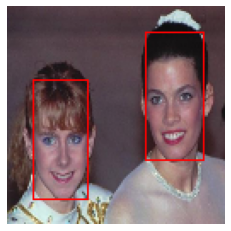

In [36]:
for x, y in training_generator():
    _id = np.random.randint(0, len(x))
    plot_example(x[_id], y[_id], IMG_SIZE, ANCHOR_SIZE)
    break

### Exercise 3: Create convolutional block

Complete conv_block function below. It's made out of **three (3)** parts Conv layer, batch normalization, and dropout layer. Conv layer has a 3x3 kernel, and padding is equal to "same". Dropout should be at 50% (0.5)

In [37]:
def conv_block(conv_features, inputs, activation = 'relu'):
    """
    Creates a single convolutional block - Conv, batch norm, dropout operations
    
    Args:
        conv_features :int: - Number of features used in the Conv2D layer
        inputs - input from the previous layer
        activation :string: - Activation function used in the Conv2D laer
    """
    x  = Conv2D(conv_features, (3, 3), padding = 'same', activation = activation)(inputs)
    x  = BatchNormalization()(x)
    x  = Dropout(0.5)(x)
    return x

In [38]:
test_conv_block(conv_block)

### Exercise 4: Create a residual block

![Residual block](https://www.researchgate.net/publication/333407474/figure/fig1/AS:763343056941057@1559006575644/The-architecture-of-the-a-residual-block-and-b-ResNet.png)
<center>Images taken from: <a href="https://www.researchgate.net/figure/The-architecture-of-the-a-residual-block-and-b-ResNet_fig1_333407474">here</a></center>
<br><br>

In the cell below, you have the **residual_block** function.
The residual block has three conv_blocks inside it, each with the same feature numbers, but mind the inputs! 
The output of this function is the **Concatenate** function of res_block inputs and last conv outputs.

NOTE: Take a look at the picture 

In [39]:
def residual_block(features, inputs):
    """
    Creates a single residual block
    
    Args:
        features :int: - Number of features used in all conv_blocks for this residual_block
        inputs - input from the previous layer
    """
    y = conv_block(features, inputs)
    y = conv_block(features, y)
    y = conv_block(features, y)
    return Concatenate(axis = -1)([inputs, y])

In [40]:
# RUN THIS CELL TO TEST YOUR CODE
test_residual_block(residual_block)

## SSD Architecture

Let's put everything together and build the SSD network!

SSD Model is a fully convolutional model; the output layer is also the convolutional layer! Since SSD does not use ROI prediction before, it tries to predict everything at the same time. The output layer of SSD is the Conv2D layer with size *[w, h, classes+4]*. 

Let's break down the last part -  **classes + 4**. The classes are pretty straightforward, but don't forget the background class! So if you have 10 classes in a dataset, this number will be 11! The **4** is for predicting bounding box coordinates.

#### Watch this video first

In [41]:
IFrame("https://www.youtube.com/embed/0frKXR-2PBY", 1000, 500)

**In some cases, IPython widgets do not work!**

If this is the case here is the like for YouTube video from cell above: https://www.youtube.com/watch?v=0frKXR-2PBY

There is a lot to learn about SSD. Here are the resources:
- https://jonathan-hui.medium.com/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06
- https://developers.arcgis.com/python/guide/how-ssd-works/


### Exercise 5: Get better loss than me

You can see the architecture I used to prepare this notebook in the cell below, which got me **0.87** loss on the **test** set. Your task here is to optimize this architecture and to get loss lower than **0.85**

In [42]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
# DO NOT CHANE CODE ABOVE THIS LINE

block1 = residual_block(16, inp)
pool1  = MaxPooling2D(pool_size = (2, 2))(block1)
block2 = residual_block(32, pool1)
pool2  = MaxPooling2D(pool_size = (2, 2))(block2)
block3 = residual_block(64, pool2)
pool3  = MaxPooling2D(pool_size = (2, 2))(block3)
block4 = residual_block(64, pool3)
pool4  = MaxPooling2D(pool_size = (2, 2))(block4)
block5 = residual_block(128, pool4)
pool5  = MaxPooling2D(pool_size = (2, 2))(block5)

# DO NOT CHANGE CODE BELOW THIS LINE!
out  = Conv2D(5, (3, 3), padding = 'same', activation = 'sigmoid')(pool5)

#create a model with one input and two outputs 
model = tf.keras.models.Model(inputs = inp, outputs = out)

In [43]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 128, 128, 16) 64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 128, 128, 16) 0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

### Losses

When working with SSD there is two parts to it's loss. Confidence loss which checks for classes and detection loss for optimizing over bounding box locations.

![](images/losses.png)
<center>Images taken from: <a href="https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab">here</a></center>
<br><br>

In [44]:
def loss(pred, y):
    """
    Custom loss function used to optimize SSD algorithm.
    This loss has two parts: Confidence loss and Location loss
    
    Read more about this loss here: https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab
    
    Args:
        preds - Model predictions
        y - real targets from a dataset
    """
    # Choose only bounding boxes where class is NOT zero (i.e not background)
    mask = y[..., 0]
    boxA = tf.boolean_mask(y, mask)
    boxB = tf.boolean_mask(pred, mask)

    # Confidence loss
    prediction_error = tf.keras.losses.binary_crossentropy(y[..., 0], pred[..., 0])
    
    # Location loss
    detection_error = tf.compat.v1.losses.absolute_difference(boxA[..., 1:], boxB[..., 1:])  
    
    # The number 10 is taken from SSD paper
    return tf.reduce_mean(prediction_error) + 10 * detection_error

## Calculating gradients

Since we are using a special loss function for our network, the optimization part is weird. We can't simply call *model.fit()*, but we need to create a custom training loop and calculate gradients semi-manually.

Link to read more about GradientTape method: https://www.tensorflow.org/guide/autodiff#gradient_tapes


### Exercise 6: Complete function for calculating gradients

By following the tutorials from the [link](https://www.tensorflow.org/guide/autodiff#gradient_tapes) complete the **grad** function.

Steps:
- Define gradient taping context
- Make predictions with a model
- Calculate loss
- Return gradients of all trainable_variables over loss AND loss itself

In [45]:
def grad(model, x, y):
    """
    Custom function for calculating gradients with respect to the loss function
    
    Args:
        model - Keras model that's being trained
        x - dataset features (inputs)
        y - real targets (also from a dataset)
    """
    # Calculate loss based on the input and predictions
    with tf.GradientTape() as tape:
        pred = model(x)
        l = loss(pred, y)
        
    # Return the gradient of the loss function with respect to the model variables 
    return tape.gradient(l, model.trainable_variables), l

### Exercise 7: Define optimizer

Define a custom optimizer for the model in the cell below. 

NOTE: I've used **Adam** optimizer, and it showed okay results.

In [46]:
optimizer = tf.keras.optimizers.Adam()

In [47]:
epochs = 20

### Exercise 8: Complete the training loop

You'll find a training loop in the cell below that runs through training/testing data and saves the model if the model performed better over the testing portion of the dataset.

Your task is to complete it by applying calculated gradients from the grad method. There are **three (3)** lines of code you should define:

- Call grad method and get gradients and loss value
- Apply gradients on the optimizer object (Defined in the *Exercise 7*)
- Append loss to the training loss list

In [20]:
train_loss = []
test_loss = []

best_loss = 1.0
for i in range(epochs):
    
    epoch_train_loss = []
    epoch_test_loss = []
    
    for x, y in training_generator():
        grads, l = grad(model, x, y)

        # update the parameters of the model 
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # calculate the metrics of the current batch
        epoch_train_loss.append(l.numpy())
    
    # CODE ABOVE THIS LINE IS MANDATORY
    # CODE BELOW THIS LINE IS OPTIONAL! BUT USE IT IF YOU WANT TO SAVE MODEL
    for x, y in test_generator():
        pred = model(x)
        l = loss(pred, y)
        epoch_test_loss.append(l.numpy())
        
    # aggregate losses
    current_train_loss = np.mean(epoch_train_loss)
    current_test_loss = np.mean(epoch_test_loss)
    
    # create history
    train_loss.append(current_train_loss)
    test_loss.append(current_test_loss)
    
    # Get some results printed
    print("Epoch {0:d}/{1:d}: Training loss: {2:0.4f}, Testing loss: {3:0.4f}".format(i+1, epochs, current_train_loss, 
              current_test_loss))
    
    # Check if there is a better model and save it
    if current_test_loss < best_loss:
        best_loss = current_test_loss
        print('Model saved')
        model.save('model_save.h5')

Epoch 1/20: Training loss: 1.3915, Testing loss: 1.1649
Epoch 2/20: Training loss: 1.2360, Testing loss: 1.1293
Epoch 3/20: Training loss: 1.1634, Testing loss: 1.0947
Epoch 4/20: Training loss: 1.1155, Testing loss: 1.0753
Epoch 5/20: Training loss: 1.0793, Testing loss: 1.0528
Model saved
Epoch 6/20: Training loss: 1.0480, Testing loss: 1.0327
Model saved
Epoch 7/20: Training loss: 1.0208, Testing loss: 1.0154
Model saved
Epoch 8/20: Training loss: 0.9978, Testing loss: 1.0015
Model saved
Epoch 9/20: Training loss: 0.9748, Testing loss: 0.9875
Model saved
Epoch 10/20: Training loss: 0.9557, Testing loss: 0.9767
Epoch 11/20: Training loss: 0.9381, Testing loss: 0.9612
Model saved
Epoch 12/20: Training loss: 0.9186, Testing loss: 0.9471
Model saved
Epoch 13/20: Training loss: 0.8998, Testing loss: 0.9333
Model saved
Epoch 14/20: Training loss: 0.8819, Testing loss: 0.9231
Epoch 15/20: Training loss: 0.8668, Testing loss: 0.9123
Epoch 16/20: Training loss: 0.8519, Testing loss: 0.9020
E

In [ ]:
# Plot run
nepochs = range(1, len(train_loss) + 1)
plt.plot(nepochs, train_loss, "ro", label="train loss")
plt.plot(nepochs, test_loss, "b*", label="test loss")
plt.title("Training Progress")
plt.legend()
plt.figure()
plt.show()

## Loading model and making predictions

In [21]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model_save.h5')

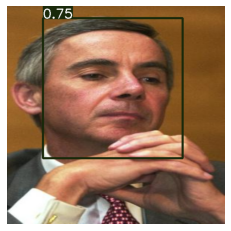

In [36]:
img_id = np.random.choice(X_test)
plot_pred(loaded_model, img_id, IMG_SIZE, ANCHOR_SIZE)